# Decision Dependent Games Simulation
## Synthetic Linear Regression Problem with Location Families
## Derivative Free Optimization Test

The following is an implementation of the DFO algorithm from "Online convex optimization in the bandit setting: gradient descent without a gradient" by Flaxman et. al. (2008)

In [1]:
import numpy as np
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from dfo_player import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

np.random.seed(46)

# Configurations

In [2]:
d_1 = 2  # Dimension of each player's data/strategy
d_2 = 2

epsilon_1 = 0.4  # Epsilon sensitivity parameters
epsilon_2 = 0.4

Sigma_x_p1 = np.eye(d_1)  # Covariance of x^k
Sigma_x_p2 = np.eye(d_2)

sigma_y_p1 = 0.01  # Variance of y^k
sigma_y_p2 = 0.01

beta_p1 = np.random.normal(size=d_1)  # Linear parameter vector
beta_p2 = np.random.normal(size=d_2)

s_1 = sample_sphere(epsilon_1,d_1+d_2)  # Performativity parameters
mu_p1 = s_1[0:d_1]
gamma_p1 = s_1[d_1:]
s_2 = sample_sphere(epsilon_2,d_1+d_2)
mu_p2 = s_2[0:d_2]
gamma_p2 = s_2[d_2:]

In [3]:
p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

# Run Game

In [4]:
p1_risks = []
p2_risks = []

num_rounds = 500000
delta = 1e-0
eta = 1e-1

player_two = DFOPlayer(delta,eta)
player_one = DFOPlayer(delta,eta)
game = DecisionDependentGame(player_one, player_two,
                             p1_data_params, p2_data_params,
                             p1_data_generating_func, p2_data_generating_func)

for i in range(num_rounds+1):
    
    game.theta_p1 = player_one.perturb_theta()
    game.theta_p2 = player_two.perturb_theta()
    
    PR_1_oracle, PR_2_oracle = game.evaluate_closed_perf_risk()
    
    game.theta_p1 = player_one.update_theta(PR_1_oracle)
    game.theta_p2 = player_two.update_theta(PR_2_oracle)
    
    p1_risks.append(PR_1_oracle)
    p2_risks.append(PR_2_oracle)
    
    if i%(num_rounds/5)==0:
        print("---------------------")
        print(f"Iteration {i}")
        print("Player 1 risk:")
        print(PR_1_oracle)

        print("Player 2 risk")
        print(PR_2_oracle)

---------------------
Iteration 0
Player 1 risk:
4.247016359268319
Player 2 risk
0.8239046873917342
---------------------
Iteration 100000
Player 1 risk:
0.022180267499506523
Player 2 risk
0.09278109312677674
---------------------
Iteration 200000
Player 1 risk:
0.02513811541909705
Player 2 risk
0.0760470477351437
---------------------
Iteration 300000
Player 1 risk:
0.02432002568634073
Player 2 risk
0.07490478843916903
---------------------
Iteration 400000
Player 1 risk:
0.031010492375628806
Player 2 risk
0.08955565127018239
---------------------
Iteration 500000
Player 1 risk:
0.030246449615400017
Player 2 risk
0.07341583079264336


## Evaluate the performative risks after DFO

In [5]:
print(f'theta_1 = {player_one.theta_history[-1]}\n theta_2 = {player_two.theta_history[-1]}')

theta_1 = [0.54291392 1.25031584]
 theta_2 = [ 0.80740254 -0.69324616]


In [6]:
game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1, PO_2 = game.evaluate_closed_perf_risk()
print(f'theta_1 = {game.theta_p1}\n theta_2 = {game.theta_p2}')
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

theta_1 = [0.54269547 1.24922824]
 theta_2 = [ 0.81066913 -0.69621181]
Player 1 PO = 0.023	Player 2 PO = 0.078


In [7]:
game.theta_p1, game.theta_p2 = game.solve_social_opt()
SO_1, SO_2 = game.evaluate_closed_perf_risk()
print(f'theta_1 = {game.theta_p1}\n theta_2 = {game.theta_p2}')
print(f'Player 1 SO = {SO_1.round(3)}\tPlayer 2 SO = {SO_2.round(3)}')

theta_1 = [0.50919138 1.21232908]
 theta_2 = [ 0.79950847 -0.70231139]
Player 1 SO = 0.025	Player 2 SO = 0.075


## Plots

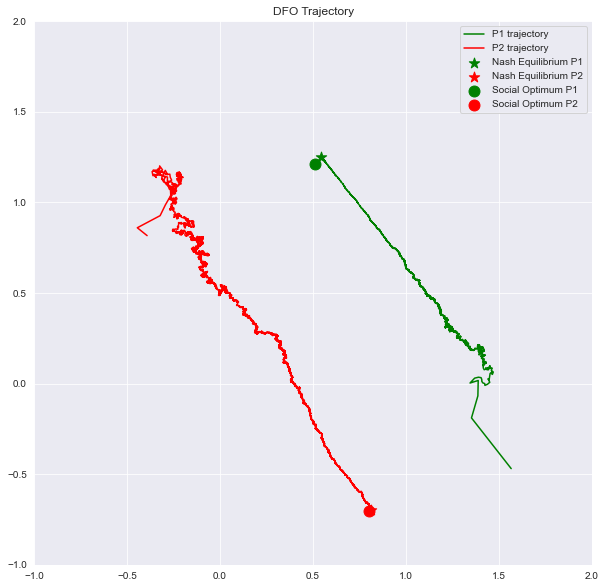

In [10]:
plt.figure(figsize=(10,10))
PO_1, PO_2 = game.solve_nash()
x_nash_p1 = PO_1[0]
y_nash_p1 = PO_1[1]
plt.scatter(x_nash_p1, y_nash_p1,
            label='Nash Equilibrium P1', marker='*', color='g', s=120)

x_nash_p2 = PO_2[0]
y_nash_p2 = PO_2[1]
plt.scatter(x_nash_p2,y_nash_p2,
            label='Nash Equilibrium P2', marker='*', color='r', s=120)

SO_1, SO_2 = game.solve_social_opt()
x_so_p1 = SO_1[0]
y_so_p1 = SO_1[1]
plt.scatter(x_so_p1, y_so_p1,
            label='Social Optimum P1', marker='o', color='g', s=120)

x_so_p2 = SO_2[0]
y_so_p2 = SO_2[1]
plt.scatter(x_so_p2,y_so_p2,
            label='Social Optimum P2', marker='o', color='r', s=120)

theta_1 = np.array(player_one.theta_history)
plt.plot(theta_1[:,0],theta_1[:,1],
         label='P1 trajectory', color='g')

theta_2 = np.array(player_two.theta_history)
plt.plot(theta_2[:,0],theta_2[:,1],
         label='P2 trajectory', color='r')

plt.ylim(-1,2)
plt.xlim(-1,2)
plt.legend()
plt.title("DFO Trajectory")
plt.show()

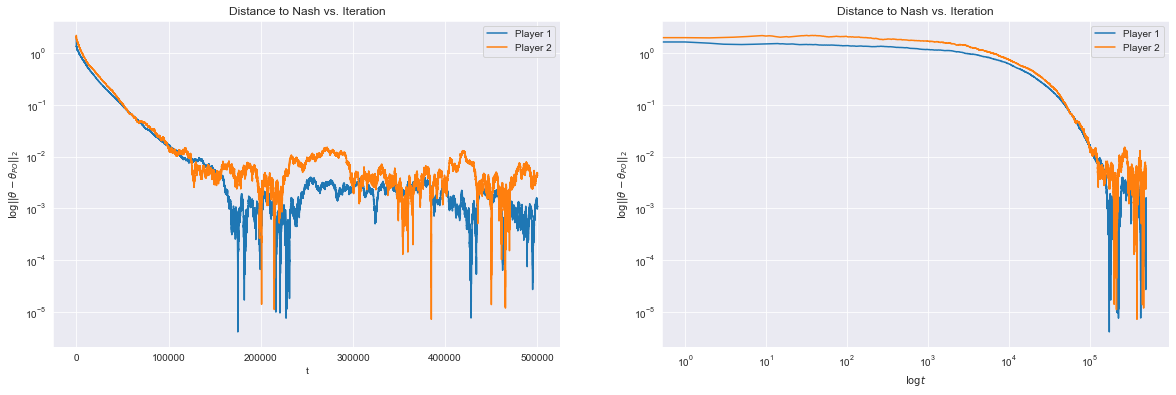

In [9]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.semilogy([t for t in range(len(player_one.theta_history))],np.linalg.norm(PO_1-np.array(player_one.theta_history),axis=1),label='Player 1')
plt.semilogy([t for t in range(len(player_two.theta_history))],np.linalg.norm(PO_2-np.array(player_two.theta_history),axis=1),label='Player 2')
plt.title("Distance to Nash vs. Iteration")
plt.ylabel(r"$\log||\theta - \theta_{PO}||_2$")
plt.xlabel(r"t")
plt.legend()
plt.subplot(1,2,2)
plt.loglog([t for t in range(len(player_one.theta_history))],np.linalg.norm(PO_1-np.array(player_one.theta_history),axis=1),label='Player 1')
plt.loglog([t for t in range(len(player_two.theta_history))],np.linalg.norm(PO_2-np.array(player_two.theta_history),axis=1),label='Player 2')
plt.title("Distance to Nash vs. Iteration")
plt.ylabel(r"$\log||\theta - \theta_{PO}||_2$")
plt.xlabel(r"$\log t$")
plt.legend()
plt.show()